In [401]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [402]:
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'cmu serif' #"Helvetica"

In [403]:
# results_path = '../runs_09/cifar10/softmax'
# results_path = '../runs_12/cifar20_100/softmax'
# results_path = '../runs_14/gtsrb/softmax'
results_path = '../runs_00_final/cifar20_100/softmax'
# results_path = '../runs_00_final/gtsrb/softmax'

In [404]:
l2d_type_lst = ['single_finetune', 'single', 'pop', 'pop_attn_sa'] # 'pop_attn', 
p_out_lst = [0.1,0.2,0.4,0.6,0.8,0.95,1.0]
seed_lst = [1071,3918,4420,5251,6637]
metrics_lst = ['cov', 'sys_acc', 'exp_acc', 'clf_acc', 'exp_acc_alone', 'clf_acc_alone', 'val_loss']

In [405]:
results = {}
for l2d_type in l2d_type_lst:
    results[l2d_type] = {}
    metrics_all = {metric:[[] for _ in range(len(p_out_lst))] for metric in metrics_lst}

    for ii,p_out in enumerate(p_out_lst):
        for seed in seed_lst:
            fn = 'eval1.0.log' #'eval.log'
            if l2d_type != 'single_finetune':
                fn_path = os.path.join(results_path, f'l2d_{l2d_type}', f'p{p_out}_seed{seed}', fn)
            else:
                fn_path = os.path.join(results_path, f'l2d_single', f'p{p_out}_seed{seed}', 'eval1.0_finetune.log')

            try:
                line = open(fn_path).readline().rstrip()
            except FileNotFoundError:
                print(fn_path)
            else:
                line_split_grp = [line.split()[i:i+2] for i in range(0, len(line.split()),2)]
                for [metric,val] in line_split_grp:
                    if metric=='cov':
                        cov = val.split('/')
                        metrics_all[metric][ii].append(int(cov[0])/int(cov[1]))
                    else:
                        metrics_all[metric][ii].append(float(val))

    for metric, vals in metrics_all.items():
        results[l2d_type][metric] = np.vstack(vals)

In [406]:
c_red = mpl.colormaps['Set1'](0)
c_blue = mpl.colormaps['Set1'](1)

In [407]:
metrics_to_text = {
    'cov':'Coverage',
    'sys_acc': 'System accuracy',
    'exp_acc': 'Expert accuracy\non deferred examples',
    'clf_acc': 'Classifier accuracy\n on non-deferred examples',
    'clf_acc_alone': 'Classifier accuracy\n on all examples',
    'val_loss': 'Test loss'
}

In [408]:
l2d_type_to_text = {
    'single': 'Single-expert',
    'pop': 'Population',
    # 'pop_attn': 'Population w/ attention'
    'pop_attn': 'Population + CA',
    'pop_attn_sa': 'Population + CA + SA',
    'single_finetune': 'Single-expert (finetune)',
}

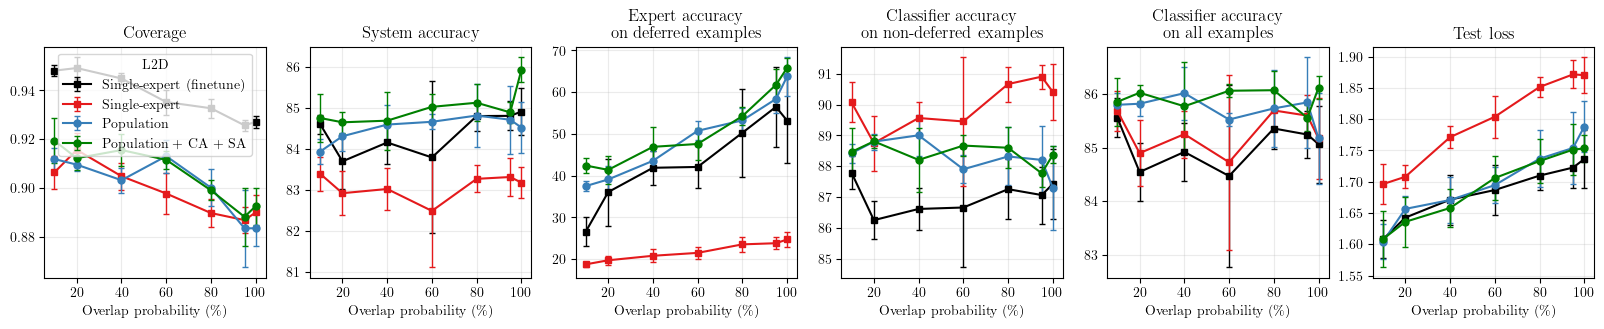

In [409]:
metrics_show = ['cov', 'sys_acc', 'exp_acc', 'clf_acc', 'clf_acc_alone', 'val_loss']
fig,axs = plt.subplots(1,len(metrics_show),figsize=(20,3))

l2d_show = l2d_type_lst
p_out_show = p_out_lst #[0.1,0.2,0.4,0.6,0.8,0.95,1.0]
res_filter = [np.where(np.array(p_out_lst)==p)[0].item() for p in p_out_show]

metric_to_col = {'single':c_red,'pop':c_blue,'pop_attn':'k', 'pop_attn_sa':'g', 'single_finetune':'k'}
metric_to_marker = {'single':'s-','pop':'o-','pop_attn':'o-', 'pop_attn_sa':'o-', 'single_finetune':'s-'}
errbar_args={'capsize':2, 'markersize':5, 'elinewidth':1., 'capthick':1., 'lw':1.5} # 'fmt':'o-'
for ax,metric in zip(axs,metrics_show):
    for l2d_type in l2d_show:
        metric_mean = np.mean(results[l2d_type][metric][res_filter], axis=1)
        metric_std = np.std(results[l2d_type][metric][res_filter], axis=1)
        # ax.plot(np.array(p_out_show), metric_mean, label=l2d_type, marker='.')
        overlap_prob = np.array(p_out_show)*100
        ax.errorbar(overlap_prob, metric_mean, yerr=metric_std, label=l2d_type_to_text[l2d_type], c=metric_to_col[l2d_type], fmt=metric_to_marker[l2d_type], **errbar_args)
        ax.set_xlabel('Overlap probability (\%)')
    ax.set_title(metrics_to_text[metric])
    ax.grid(True, alpha=0.25)
    
axs[0].legend(title='L2D')
# fig.savefig('cifar20_new.png', dpi=600, facecolor='white', bbox_inches="tight")
# fig.savefig('gtsrb_finetune.png', dpi=600, facecolor='white', bbox_inches="tight")